# 导入模块

In [1]:
import logging
import json
import torch
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BertModel
from sklearn import metrics
from transformers.models.bert.modeling_bert import BertPreTrainedModel
from transformers.models.bert.modeling_bert import BertEmbeddings, BertEncoder, BertPooler
from transformers import BertTokenizer

from loggers import get_stderr_file_logger
from heatmap import heatmap,annotate_heatmap

from layers.dynamic_rnn import DynamicLSTM
from cmgcni import CMGCNI
from train import train, evaluate_acc_f1
from cmgcni import get_cmgcni_optimizer
from cmgcni import MultimodalConfig
from mustards import MUStartDataset
from cmgcni import train_cmgcni_model


In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

# 准备模型

In [3]:
class CMGCN(nn.Module):
    def __init__(self):
        super(CMGCN, self).__init__()
        print('create CMGCN model')
        self.bert = BertModel.from_pretrained(pretrained_root_path + 'bert-base-uncased/')
        self.text_lstm = DynamicLSTM(768,4,num_layers=1,batch_first=True,bidirectional=True)
        self.vit_fc = nn.Linear(768,2*4)
        self.gc1 = GraphConvolution(2*4, 2*4)
        self.gc2 = GraphConvolution(2*4, 2*4)
        self.fc = nn.Linear(2*4,2)
        
    def forward(self, inputs):
        bert_indices = inputs['bert_indices']
        graph = inputs['big_graphs']
        box_vit = inputs['video_features_p']
        bert_text_len = torch.sum(bert_indices != 0, dim = -1)
        outputs = self.bert(bert_indices)
        encoder_layer = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        bert_text_len = bert_text_len.cpu()
        logger.info(bert_text_len.device)
        text_out, (_, _) = self.text_lstm(encoder_layer, bert_text_len)
        # 与原始代码不同，这里因为进行了全局的特征填充，导致text_out可能无法达到填充长度，补充为0
        if text_out.shape[1] < encoder_layer.shape[1]:
            pad = torch.zeros((text_out.shape[0],encoder_layer.shape[1]-text_out.shape[1],text_out.shape[2])).to(device)
            text_out = torch.cat((text_out,pad),dim=1)

        box_vit = box_vit.float()
        box_vit = self.vit_fc(box_vit)
        features = torch.cat([text_out, box_vit], dim=1)

        graph = graph.float()
        x = F.relu(self.gc1(features, graph))
        x = F.relu(self.gc2(x,graph))
        
        alpha_mat = torch.matmul(features,x.transpose(1,2))
        alpha_mat = alpha_mat.sum(1, keepdim=True)
        alpha = F.softmax(alpha_mat, dim = 2)
        x = torch.matmul(alpha, x).squeeze(1)
        
        output = self.fc(x)
        return output
    

In [4]:
class MagBertForSequenceClassification(nn.Module):
    def __init__(self, multimodal_config):
        super(MagBertForSequenceClassification, self).__init__()
        print('create MagBertForSequenceClassification model')
        self.mag_bert = MAG_BertModel.from_pretrained(pretrained_root_path + 'bert-base-uncased/',multimodal_config=multimodal_config)
        self.dropout = nn.Dropout(0.1) # bert config 中的设置
        self.classifier = nn.Linear(768,2)
        
    def forward(self, inputs):
        bert_indices = inputs['bert_indices']
        box_vit = inputs['video_features_p']
        bert_text_len = torch.sum(bert_indices != 0, dim = -1)
        # 2,24, audio_feature key 2 33 33 , 2,10 768 
        visual = box_vit
        acoustic = inputs['audio_feature']
        self.align_subnet = AlignSubNet(bert_indices.size(1))
        bert_indices, acoustic, visual= self.align_subnet(bert_indices,acoustic,visual)

        acoustic = acoustic.float()
        
        outputs = self.mag_bert(bert_indices, visual, acoustic)
        
        pooled_output = outputs[1]
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        output = logits
        return output
    
class EF_LSTM(nn.Module):
    def __init__(self):
        super(EF_LSTM, self).__init__()
        print('create EF_LSTM model')
        self.bert = BertModel.from_pretrained(pretrained_root_path +'bert-base-uncased/')
        self.norm = nn.BatchNorm1d(TEXT_SEQ_LEN)
        self.lstm = nn.LSTM(ACOUSTIC_DIM+VISUAL_DIM+TEXT_DIM, 64, num_layers=2, dropout=0.3, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(64,64)
        self.out = nn.Linear(64,2)
        
    def forward(self, inputs):
        bert_indices = inputs['bert_indices']
        # graph = inputs['big_graphs']
        box_vit = inputs['video_features_p']
        bert_text_len = torch.sum(bert_indices != 0, dim = -1)
        # 2,24, audio_feature key 2 33 33 , 2,10 768 
        visual = box_vit
        acoustic = inputs['audio_feature']
        self.align_subnet = AlignSubNet(bert_indices.size(1))
        bert_indices, acoustic, visual= self.align_subnet(bert_indices,acoustic,visual)
        acoustic = acoustic.float()
        outputs = self.bert(bert_indices)
        encoder_layer = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        text_x = encoder_layer
        audio_x = acoustic
        video_x = visual
        x = torch.cat([text_x, audio_x, video_x], dim=-1)
        x = self.norm(x)
        _, final_states = self.lstm(x)
        x = self.dropout(final_states[0][-1].squeeze(dim=0))
        x = F.relu(self.linear(x), inplace=True)
        x = self.dropout(x)
        output = self.out(x)
        
        return output

from models.subNets.FeatureNets import SubNet,TextSubNet

class LF_DNN(nn.Module):
    def __init__(self):
        super(LF_DNN, self).__init__()
        print('create LF_DNN model')
        self.bert = BertModel.from_pretrained(pretrained_root_path + 'bert-base-uncased/')
        self.audio_in = ACOUSTIC_DIM
        self.video_in = VISUAL_DIM
        self.text_in = TEXT_DIM
        self.audio_hidden = 8
        self.video_hidden = 64
        self.text_hidden = 64
        self.text_out = 32
        self.post_fusion_dim = 32
        self.audio_prob, self.video_prob, self.text_prob, self.post_fusion_prob = 0.2, 0.2, 0.2, 0.2
        self.audio_subnet = SubNet(self.audio_in, self.audio_hidden, self.audio_prob)
        self.video_subnet = SubNet(self.video_in, self.video_hidden, self.video_prob)
        self.text_subnet = TextSubNet(self.text_in, self.text_hidden, self.text_out, dropout=self.text_prob)

        self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
        self.post_fusion_layer_1 = nn.Linear(self.text_out + self.video_hidden + self.audio_hidden,
                                             self.post_fusion_dim)
        self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
        self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, 2)
        
        
    def forward(self, inputs):
        bert_indices = inputs['bert_indices']
        box_vit = inputs['video_features_p']
        bert_text_len = torch.sum(bert_indices != 0, dim = -1)
        # 2,24, audio_feature key 2 33 33 , 2,10 768 
        visual = box_vit
        acoustic = inputs['audio_feature']
        self.align_subnet = AlignSubNet(bert_indices.size(1))
        bert_indices, acoustic, visual= self.align_subnet(bert_indices,acoustic,visual)
        acoustic = acoustic.float()
        outputs = self.bert(bert_indices)
        encoder_layer = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        text_x = encoder_layer
        audio_x = acoustic
        video_x = visual
        audio_x = torch.mean(audio_x,1,True)
        video_x = torch.mean(video_x,1,True)
        audio_x[audio_x != audio_x] = 0
        video_x[video_x != video_x] = 0
        audio_x = audio_x.squeeze(1)
        video_x = video_x.squeeze(1)
        
        audio_h = self.audio_subnet(audio_x)
        video_h = self.video_subnet(video_x)
        text_h = self.text_subnet(text_x)
        
        fusion_h = torch.cat([audio_h, video_h, text_h], dim=-1)

        x = self.post_fusion_dropout(fusion_h)
        x = F.relu(self.post_fusion_layer_1(x), inplace=True)
        x = F.relu(self.post_fusion_layer_2(x), inplace=True)
        output = self.post_fusion_layer_3(x)
               
        return output

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
class AuViSubNet(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, num_layers=1, dropout=0.2, bidirectional=False):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            num_layers: specify the number of layers of LSTMs.
            dropout: dropout probability
            bidirectional: specify usage of bidirectional LSTM
        Output:
            (return value in forward) a tensor of shape (batch_size, out_size)
        '''
        super(AuViSubNet, self).__init__()
        self.rnn = nn.LSTM(in_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(hidden_size, out_size)

    def forward(self, x, lengths):
        '''
        x: (batch_size, sequence_len, in_size)
        '''
        packed_sequence = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, final_states = self.rnn(packed_sequence)
        h = self.dropout(final_states[0].squeeze())
        y_1 = self.linear_1(h)
        return y_1
    
    
class SELF_MM(nn.Module):
    def __init__(self):
        super(SELF_MM, self).__init__()
        print('create SELF_MM model')
        
        self.audio_in = ACOUSTIC_DIM
        self.video_in = VISUAL_DIM
        self.text_in = TEXT_DIM
        self.audio_hidden = 8
        self.video_hidden = 64
        self.text_hidden = 64
        self.text_out = 768
        self.post_text_dim = 32
        self.audio_out = 8
        self.post_audio_dim = 8 
        self.video_out = 32
        self.post_video_dim = 32 
        self.post_fusion_dim = 32
        self.audio_prob, self.video_prob, self.text_prob, self.post_fusion_prob = 0.2, 0.2, 0.2, 0.2
        
        self.bert = BertModel.from_pretrained(pretrained_root_path + 'bert-base-uncased/')
        self.audio_model = AuViSubNet(self.audio_in, self.audio_hidden, self.audio_out, dropout = self.audio_prob)
        self.video_model = AuViSubNet(self.video_in, self.video_hidden, self.video_out, dropout = self.video_prob)

        self.post_fusion_dropout = nn.Dropout(p=self.post_fusion_prob)
        self.post_fusion_layer_1 = nn.Linear(self.text_out + self.video_out + self.audio_out,
                                             self.post_fusion_dim)
        self.post_fusion_layer_2 = nn.Linear(self.post_fusion_dim, self.post_fusion_dim)
        self.post_fusion_layer_3 = nn.Linear(self.post_fusion_dim, 1)
        

        # the classify layer for text
        self.post_text_dropout = nn.Dropout(p=self.text_prob)
        self.post_text_layer_1 = nn.Linear(self.text_out, self.post_text_dim)
        self.post_text_layer_2 = nn.Linear(self.post_text_dim, self.post_text_dim)
        self.post_text_layer_3 = nn.Linear(self.post_text_dim, 1)
        
        
        # the classify layer for audio
        self.post_audio_dropout = nn.Dropout(p=self.audio_prob)
        self.post_audio_layer_1 = nn.Linear(self.audio_out, self.post_audio_dim)
        self.post_audio_layer_2 = nn.Linear(self.post_audio_dim, self.post_audio_dim)
        self.post_audio_layer_3 = nn.Linear(self.post_audio_dim, 1)

        # the classify layer for video

        self.post_video_dropout = nn.Dropout(p=self.video_prob)
        self.post_video_layer_1 = nn.Linear(self.video_out, self.post_video_dim)
        self.post_video_layer_2 = nn.Linear(self.post_video_dim, self.post_video_dim)
        self.post_video_layer_3 = nn.Linear(self.post_video_dim, 1)
        
        
    def forward(self, inputs):
        bert_indices = inputs['bert_indices']
        box_vit = inputs['video_features_p']
        bert_text_len = torch.sum(bert_indices != 0, dim = -1)
        # 2,24, audio_feature key 2 33 33 , 2,10 768 
        visual = box_vit
        acoustic = inputs['audio_feature']
        self.align_subnet = AlignSubNet(bert_indices.size(1))
        bert_indices, acoustic, visual= self.align_subnet(bert_indices,acoustic,visual)
        acoustic = acoustic.float()
        outputs = self.bert(bert_indices)
        encoder_layer = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        text_x = encoder_layer
        audio_x = acoustic
        video_x = visual
        
        text = pooled_output
        bert_text_len = bert_text_len.cpu()
        audio = self.audio_model(audio_x, bert_text_len)
        video = self.video_model(video_x, bert_text_len)
        
        # fusion
        fusion_h = torch.cat([text, audio, video], dim=-1)
        fusion_h = self.post_fusion_dropout(fusion_h)
        fusion_h = F.relu(self.post_fusion_layer_1(fusion_h), inplace=False)
        # # text
        text_h = self.post_text_dropout(text)
        text_h = F.relu(self.post_text_layer_1(text_h), inplace=False)
        # audio
        audio_h = self.post_audio_dropout(audio)
        audio_h = F.relu(self.post_audio_layer_1(audio_h), inplace=False)
        # vision
        video_h = self.post_video_dropout(video)
        video_h = F.relu(self.post_video_layer_1(video_h), inplace=False)

        # classifier-fusion
        x_f = F.relu(self.post_fusion_layer_2(fusion_h), inplace=False)
        output_fusion = self.post_fusion_layer_3(x_f)

        # classifier-text
        x_t = F.relu(self.post_text_layer_2(text_h), inplace=False)
        output_text = self.post_text_layer_3(x_t)

        # classifier-audio
        x_a = F.relu(self.post_audio_layer_2(audio_h), inplace=False)
        output_audio = self.post_audio_layer_3(x_a)

        # classifier-vision
        x_v = F.relu(self.post_video_layer_2(video_h), inplace=False)
        output_video = self.post_video_layer_3(x_v)
        
        res = {
            'M': output_fusion, 
            'T': output_text,
            'A': output_audio,
            'V': output_video,
            'Feature_t': text_h,
            'Feature_a': audio_h,
            'Feature_v': video_h,
            'Feature_f': fusion_h,
        }
        return res
    
    

# 初始模型参数，

In [5]:
def init_cmgcn_params(cmgcn_model):
    for child in cmgcn_model.children():
        # print(type(child) != BertModel)
        if type(child) != BertModel:
            for p in child.parameters():
                if p.requires_grad :
                    if len(p.shape) > 1:
                        torch.nn.init.xavier_uniform_(p)
                    else:
                        import math
                        stdv = 1.0 / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    logger.error('init_cmgcn_params()')

In [6]:
def init_magbert_params(magbert_forseqcls):
    for child in magbert_forseqcls.children():
        if type(child) != MAG_BertModel:
            for p in child.parameters():
                if p.requires_grad :
                    if len(p.shape) > 1:
                        torch.nn.init.xavier_uniform_(p)
                    else:
                        import math
                        stdv = 1.0 / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    logger.error('init_magbert_params()')

In [7]:
def init_ef_lstm_params(ef_lstm_model):
    for child in ef_lstm_model.children():
        if type(child) != BertModel:
            for p in child.parameters():
                if p.requires_grad :
                    if len(p.shape) > 1:
                        torch.nn.init.xavier_uniform_(p)
                    else:
                        import math
                        stdv = 1.0 / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    logger.error('init_ef_lstm_params()')
   

In [8]:
 
def init_lf_dnn_params(lf_dnn_model):
    for child in lf_dnn_model.children():
        if type(child) != BertModel:
            for p in child.parameters():
                if p.requires_grad :
                    if len(p.shape) > 1:
                        torch.nn.init.xavier_uniform_(p)
                    else:
                        import math
                        stdv = 1.0 / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    logger.error('init_lf_dnn_params()')
    

In [9]:
def init_self_mm_params(self_mm_model):
    for child in self_mm_model.children():
        if type(child) != BertModel:
            for p in child.parameters():
                if p.requires_grad :
                    if len(p.shape) > 1:
                        torch.nn.init.xavier_uniform_(p)
                    else:
                        import math
                        stdv = 1.0 / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    logger.error('init_self_mm_params()')

# 准备optimizer函数，

In [10]:
def get_cmgcn_optimizer(cmgcn_model):
    optimizer = torch.optim.Adam([
        {'params':cmgcn_model.bert.parameters(),'lr':2e-5},
        {'params':cmgcn_model.text_lstm.parameters(),},
        {'params':cmgcn_model.vit_fc.parameters(),},
        {'params':cmgcn_model.gc1.parameters(),},
        {'params':cmgcn_model.gc2.parameters(),},
        {'params':cmgcn_model.fc.parameters(),},
    ],lr=0.001,weight_decay=1e-5)
    # optimizer = torch.optim.Adam(cmgcn_model.parameters(),lr=1e-3,weight_decay=1e-5)
    return optimizer

In [11]:
def get_magbert_optimizer(magbert_forseqcls):
    optimizer = torch.optim.Adam([
        {'params':magbert_forseqcls.mag_bert.parameters(),'lr':1e-5},
        {'params':magbert_forseqcls.classifier.parameters(),},
        {'params':magbert_forseqcls.dropout.parameters(),},
    ],lr=0.001,weight_decay=1e-5)
    return optimizer

In [12]:
def get_ef_lstm_optimizer(ef_lstm_model):
    optimizer = torch.optim.Adam([
        {'params':ef_lstm_model.bert.parameters(),'lr':1e-5},
        {'params':ef_lstm_model.norm.parameters(),},
        {'params':ef_lstm_model.lstm.parameters(),},
        {'params':ef_lstm_model.dropout.parameters(),},
        {'params':ef_lstm_model.linear.parameters(),},
        {'params':ef_lstm_model.out.parameters(),},
    ],lr=0.001,weight_decay=1e-5)
    return optimizer

In [13]:
def get_lf_dnn_optimizer(lf_dnn_model):
    optimizer = torch.optim.Adam([
        {'params':lf_dnn_model.bert.parameters(),'lr':1e-5},
        {'params':lf_dnn_model.audio_subnet.parameters(),},
        {'params':lf_dnn_model.video_subnet.parameters(),},
        {'params':lf_dnn_model.text_subnet.parameters(),},
        {'params':lf_dnn_model.post_fusion_dropout.parameters(),},
        {'params':lf_dnn_model.post_fusion_layer_1.parameters(),},
        {'params':lf_dnn_model.post_fusion_layer_2.parameters(),},
        {'params':lf_dnn_model.post_fusion_layer_3.parameters(),},
    ],lr=0.001,weight_decay=1e-5)
    return optimizer

In [14]:
def get_self_mm_optimizer(self_mm_model):
    optimizer = torch.optim.Adam([
        {'params':self_mm_model.bert.parameters(),'lr':1e-5},
        {'params':self_mm_model.audio_model.parameters(),},
        {'params':self_mm_model.video_model.parameters(),},
        
        {'params':self_mm_model.post_fusion_dropout.parameters(),},
        {'params':self_mm_model.post_fusion_layer_1.parameters(),},
        {'params':self_mm_model.post_fusion_layer_2.parameters(),},
        {'params':self_mm_model.post_fusion_layer_3.parameters(),},
        
        {'params':self_mm_model.post_text_dropout.parameters(),},
        {'params':self_mm_model.post_text_layer_1.parameters(),},
        {'params':self_mm_model.post_text_layer_2.parameters(),},
        {'params':self_mm_model.post_text_layer_3.parameters(),},
        
        {'params':self_mm_model.post_audio_dropout.parameters(),},
        {'params':self_mm_model.post_audio_layer_1.parameters(),},
        {'params':self_mm_model.post_audio_layer_2.parameters(),},
        {'params':self_mm_model.post_audio_layer_3.parameters(),},
        
        {'params':self_mm_model.post_video_dropout.parameters(),},
        {'params':self_mm_model.post_video_layer_1.parameters(),},
        {'params':self_mm_model.post_video_layer_2.parameters(),},
        {'params':self_mm_model.post_video_layer_3.parameters(),},
        
    ],lr=0.001,weight_decay=1e-5)
    return optimizer

# 调试模型的形状函数

In [15]:
    

def debug_self_mm_model(model):
    d = MUStartDataset('train')
    dl = DataLoader(d, batch_size=2, num_workers=0, shuffle=False)
    batch = iter(dl).next()
    batch.keys()
    inputs ={}
    for key in batch.keys():
        inputs[key] = batch[key].to(device)
    outputs = model(inputs)
    print('debug_model: ',type(model))
    print([(k,v.shape) for k,v in outputs.items()])
    
    
    

# train and eval

In [16]:
def evaluate_self_mm_acc_f1(data_loader,model):
    n_correct, n_total = 0, 0
    targets_all, outputs_all = None, None
    model.eval()
    with torch.no_grad():
        for i_batch,batch in enumerate(data_loader):
            inputs ={}
            for key in batch.keys():
                inputs[key] = batch[key].to(device)
            outputs = model(inputs)
            targets = batch['labels'].to(device)
            output_label = outputs['M'].view(-1)
            output_label[output_label>=0.5] = 1.0
            output_label[output_label<0.5] = 0.0
            
            n_correct += (output_label == targets).sum().item()
            n_total += len(outputs['M'])
            
            if targets_all is None:
                targets_all = targets
                outputs_all = outputs['M']
            else:
                targets_all = torch.cat((targets_all,targets), dim=0)
                outputs_all = torch.cat((outputs_all,outputs['M']), dim=0)
    
    
    acc = n_correct / n_total
    f1 = metrics.f1_score(targets_all.cpu(), outputs_all.cpu(), labels=[0,1], average='macro', zero_division=0)
    precision = metrics.precision_score(targets_all.cpu(), outputs_all.cpu(), labels=[0,1], average='macro', zero_division=0)
    recall = metrics.recall_score(targets_all.cpu(), outputs_all.cpu(), labels=[0,1], average='macro', zero_division=0)

    return acc,f1,precision,recall

In [17]:
def train_self_mm(model,optimizer,model_save_path,times):
    # 多任务self逻辑
    train_samples = len(train_dataset)
    label_map = {
        'fusion': torch.zeros(train_samples, requires_grad=False).to(device),
        'text': torch.zeros(train_samples, requires_grad=False).to(device),
        'audio': torch.zeros(train_samples, requires_grad=False).to(device),
        'vision': torch.zeros(train_samples, requires_grad=False).to(device)
    }
    # init labels
    for batch_data in train_dataloader:
        labels_m = batch_data['labels'].float().to(device)
        indexes = batch_data['index'].view(-1)
        label_map['fusion'][indexes] = labels_m
        label_map['text'][indexes] = labels_m
        label_map['audio'][indexes] = labels_m
        label_map['vision'][indexes] = labels_m
        
    logger.info('label_map[fusion]: {}'.format(label_map['fusion'].shape))
    max_val_acc , max_val_f1, max_val_epoch, global_step = 0, 0, 0, 0
    val_accs = []
    for i_epoch in range(num_epoch):
        epochs = i_epoch + 1             # for same with self_mm original code 
        
        logger.error('epochs:{}'.format(epochs))
        y_pred = {'M': [], 'T': [], 'A': [], 'V': []}
        y_true = {'M': [], 'T': [], 'A': [], 'V': []}
        train_loss = 0.0
        
        n_correct, n_total, loss_total = 0, 0, 0
        for i_batch,batch in enumerate(train_dataloader):
            global_step += 1
            model.train()
            optimizer.zero_grad()
            inputs ={}
            for key in batch.keys():
                inputs[key] = batch[key].to(device)
                
            indexes = batch['index'].view(-1)
            outputs = model(inputs)
            
            tasks = 'MTAV'
            name_map = {
                'M': 'fusion',
                'T': 'text',
                'A': 'audio',
                'V': 'vision'
            }
            logger.info('label_map[fusion]: {}'.format(label_map['fusion'].shape))
            logger.info('indexes: {}'.format(indexes))
            for m in tasks:
                y_pred[m].append(outputs[m].cpu())
                y_true[m].append(label_map[name_map[m]][indexes].cpu())
                
            loss = 0.0
            def weighted_loss(y_pred,y_true,indexes=None, mode = 'fusion'):
                if mode == 'fusion':
                    weighted = torch.ones_like(y_pred)
                else:
                    weighted = torch.tanh(torch.abs(label_map[mode][indexes] - label_map['fusion'][indexes]))
                loss = torch.mean(weighted * torch.abs(y_pred - y_true))
                return loss
                
            for m in tasks:
                loss += weighted_loss(outputs[m],label_map[name_map[m]][indexes],indexes = indexes, mode = name_map[m])
            
            loss.backward()
            train_loss += loss.item()
            # update features 
            f_fusion = outputs['Feature_f'].detach()
            f_text = outputs['Feature_t'].detach()
            f_audio = outputs['Feature_a'].detach()
            f_vision = outputs['Feature_v'].detach()
            def update_labels(f_fusion, f_text, f_audio, f_vision, cur_epoches, indexes, outputs):
                MIN = 1e-8
                def update_single_label(f_single, mode):
                    d_sp = torch.norm(f_single - center_map[mode]['pos'], dim=-1) 
                    d_sn = torch.norm(f_single - center_map[mode]['neg'], dim=-1) 
                    delta_s = (d_sn - d_sp) / (d_sp + MIN)
                    alpha = delta_s / (delta_f + MIN)
                    
                    new_labels = 0.5 * alpha * label_map['fusion'][indexes] + \
                        0.5 * (label_map['fusion'][indexes] + delta_s - delta_f)
                    new_labels = torch.clamp(new_labels, min=0.0, max=1.0)
                    
                    n = cur_epoches
                    label_map[mode][indexes] = (n - 1) / (n + 1) * label_map[mode][indexes] \
                      + 2 / (n + 1) * new_labels
                    
                d_fp = torch.norm(f_fusion - center_map['fusion']['pos'], dim=-1)
                d_fn = torch.norm(f_fusion - center_map['fusion']['neg'], dim=-1) 
                delta_f = (d_fn - d_fp) / (d_fp + MIN)
                
                update_single_label(f_text, mode='text')
                update_single_label(f_audio, mode='audio')
                update_single_label(f_vision, mode='vision')
            
            if epochs > 1:
                update_labels(f_fusion, f_text, f_audio, f_vision, epochs, indexes, outputs)
            
            logger.info('label_map : ' + str(label_map))
            post_fusion_dim = 32
            post_text_dim = 32
            post_audio_dim = 8
            post_video_dim = 32
            feature_map = {
                'fusion': torch.zeros(train_samples, post_fusion_dim, requires_grad=False).to(device),
                'text': torch.zeros(train_samples, post_text_dim, requires_grad=False).to(device),
                'audio': torch.zeros(train_samples, post_audio_dim, requires_grad=False).to(device),
                'vision': torch.zeros(train_samples, post_video_dim, requires_grad=False).to(device),
            }
            def update_features(f_fusion, f_text, f_audio, f_vision, indexes):
                feature_map['fusion'][indexes] = f_fusion
                feature_map['text'][indexes] = f_text
                feature_map['audio'][indexes] = f_audio
                feature_map['vision'][indexes] = f_vision
            
            center_map = {
                'fusion': {
                    'pos': torch.zeros(post_fusion_dim, requires_grad=False).to(device),
                    'neg': torch.zeros(post_fusion_dim, requires_grad=False).to(device),
                },
                'text': {
                    'pos': torch.zeros(post_text_dim, requires_grad=False).to(device),
                    'neg': torch.zeros(post_text_dim, requires_grad=False).to(device),
                },
                'audio': {
                    'pos': torch.zeros(post_audio_dim, requires_grad=False).to(device),
                    'neg': torch.zeros(post_audio_dim, requires_grad=False).to(device),
                },
                'vision': {
                    'pos': torch.zeros(post_video_dim, requires_grad=False).to(device),
                    'neg': torch.zeros(post_video_dim, requires_grad=False).to(device),
                }
            }
            def update_centers():
                def update_single_center(mode):
                    neg_indexes = label_map[mode] <= 0.5   # [0 1] label 
                    pos_indexes = label_map[mode] > 0.5
                    if torch.any(pos_indexes):
                        center_map[mode]['pos'] = torch.mean(feature_map[mode][pos_indexes], dim=0)
                    if torch.any(neg_indexes):
                        center_map[mode]['neg'] = torch.mean(feature_map[mode][neg_indexes], dim=0)
                    # 如果样本只有正例 ，则负例会出现nan的情况
                    
                update_single_center(mode='fusion')
                update_single_center(mode='text')
                update_single_center(mode='audio')
                update_single_center(mode='vision')
                
                
            update_features(f_fusion, f_text, f_audio, f_vision, indexes)
            update_centers()
            optimizer.step()
            
            targets = batch['labels'].to(device)
            # outputs['M'] >= 0.5 1 
            # outputs['M'] < 0.5 0 
            output_label = outputs['M'].view(-1)
            output_label[output_label>=0.5] = 1.0
            output_label[output_label<0.5] = 0.0

            n_correct += (output_label == targets).sum().item()
            n_total += len(outputs['M'])
            loss_total += train_loss * len(outputs['M'])

            train_acc = n_correct / n_total
            train_loss = loss_total / n_total

            if global_step % log_step == 0:
                val_acc, val_f1, val_precision, val_recall = evaluate_self_mm_acc_f1(valid_dataloader,model)
                val_accs.append(val_acc)
                logger.error('train_loss:{} val_acc:{}'.format(train_loss,val_acc))
                if val_acc >= max_val_acc:
                    max_val_f1 = val_f1
                    max_val_acc = val_acc
                    max_val_epoch = i_epoch
                    torch.save(model.state_dict(),model_save_path)
                    logger.info('save the model to {}'.format(model_save_path))

        if i_epoch - max_val_epoch > early_stop:
            logger.error('early stop')
            break

        # break
    model.load_state_dict(torch.load(model_save_path))
    test_acc, test_f1,test_precision,test_recall = evaluate_self_mm_acc_f1(test_dataloader,model)
    logger.error('final results.'+'-' * 20)
    logger.error('test_acc: {}'.format(test_acc))
    logger.error('test_f1: {}'.format(test_f1))
    logger.error('test_precision: {}'.format( test_precision))
    logger.error('test_recall: {}'.format( test_recall))
    logger.error('final results.'+'-' * 20)
    
    import pandas as pd

    data = {
        train_model_name:val_accs,
    }
    df = pd.DataFrame(data)
    df.to_csv('6.{}.accs.{}.csv'.format(times, train_model_name),index=False)
    
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt

    fig = df.plot(title = 'mag_bert',figsize=(8, 6), fontsize=26).get_figure()
    fig.savefig('6.{}.accs.{}.jpg'.format(times, train_model_name))
    plt.show()
    
    return test_acc, test_f1,test_precision,test_recall 
    
    

# 准备训练不同模型的函数

In [18]:
# prepare model 
def train_cmgcn_model(times=1):
    cmgcn_model = CMGCN().to(device)
    init_cmgcn_params(cmgcn_model) 
    cmgcn_optimizer = get_cmgcn_optimizer(cmgcn_model)
    debug_model(cmgcn_model)
    cmgcn_model_path = '../cmgcn_model.pth'

    model = cmgcn_model
    optimizer = cmgcn_optimizer
    model_save_path = cmgcn_model_path
    logger.error('start train:' + '-'*10)
    test_acc, test_f1,test_precision,test_recall  = train(model,optimizer,model_save_path,times)
    return test_acc, test_f1,test_precision,test_recall 
   

In [19]:
def train_magbert_forseqcls(times=1):
    magbert_forseqcls = MagBertForSequenceClassification(multimodal_config = multimodal_config ).to(device)
    init_magbert_params(magbert_forseqcls)
    magbert_optimizer = get_magbert_optimizer(magbert_forseqcls)
    debug_model(magbert_forseqcls)
    magbert_model_path = '../magbert_model.pth'

    model = magbert_forseqcls
    optimizer = magbert_optimizer
    model_save_path = magbert_model_path
    logger.error('start train:' + '-'*10)
    test_acc, test_f1,test_precision,test_recall  = train(model,optimizer,model_save_path,times)
    return test_acc, test_f1,test_precision,test_recall 
    

In [20]:
def train_ef_lstm_model(times=1):
    ef_lstm_model = EF_LSTM().to(device)
    init_ef_lstm_params(ef_lstm_model)
    ef_lstm_optimizer = get_ef_lstm_optimizer(ef_lstm_model)
    debug_model(ef_lstm_model)
    ef_lstm_model_path = '../ef_lstm_model.pth'

    model = ef_lstm_model
    optimizer = ef_lstm_optimizer
    model_save_path = ef_lstm_model_path
    logger.error('start train:' + '-'*10)
    test_acc, test_f1,test_precision,test_recall  = train(model,optimizer,model_save_path,times)
    return test_acc, test_f1,test_precision,test_recall 
    

In [21]:
def train_lf_dnn_model(times=1):
    lf_dnn_model = LF_DNN().to(device)
    init_lf_dnn_params(lf_dnn_model)
    lf_dnn_optimizer = get_lf_dnn_optimizer(lf_dnn_model)
    debug_model(lf_dnn_model)
    lf_dnn_model_path = '../lf_dnn_model.pth'

    model = lf_dnn_model
    optimizer = lf_dnn_optimizer
    model_save_path = lf_dnn_model_path
    logger.error('start train:' + '-'*10)
    test_acc, test_f1,test_precision,test_recall  = train(model,optimizer,model_save_path,times)
    return test_acc, test_f1,test_precision,test_recall 
    

In [22]:
def train_self_mm_model(times=1):
    self_mm_model = SELF_MM().to(device)
    init_self_mm_params(self_mm_model)
    self_mm_optimizer = get_self_mm_optimizer(self_mm_model)
    debug_self_mm_model(self_mm_model)
    self_mm_model_path = '../self_mm_model.pth'

    model = self_mm_model
    optimizer = self_mm_optimizer
    model_save_path = self_mm_model_path
    logger.error('start train:' + '-'*10)
    test_acc, test_f1,test_precision,test_recall  = train_self_mm(model,optimizer,model_save_path,times)
    return test_acc, test_f1,test_precision,test_recall
    

In [24]:
def run_models():
    # ['EF_LSTM','lf_dnn', 'cmgcni','self_mm','mag_bert',]
    for train_model_name in ['cmgcni']:
        if train_model_name == 'EF_LSTM': 
            run_five_times_result(train_ef_lstm_model)
        elif train_model_name == 'lf_dnn':
            run_five_times_result(train_lf_dnn_model)
        elif train_model_name == 'self_mm':
            run_five_times_result(train_self_mm_model)
        elif train_model_name == 'mag_bert':
            run_five_times_result(train_magbert_forseqcls)
        elif train_model_name == 'cmgcn':
            run_five_times_result(train_cmgcn_model)
        elif train_model_name == 'cmgcni':
            run_five_times_result(train_cmgcni_model)
    

# 开始训练

root[line:7] - This is a WARNING message
ablation[line:15] - times: 0


create CMGCNI model
Initializing MAG with beta_shift:1.0 hidden_prob:0.5


Some weights of the model checkpoint at ../tools/bert-base-uncased/ were not used when initializing MAG_BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MAG_BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MAG_BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MAG_BertModel were not initialized from the model checkpoint at ../tools/bert-base-uncased/ and are newly initialized

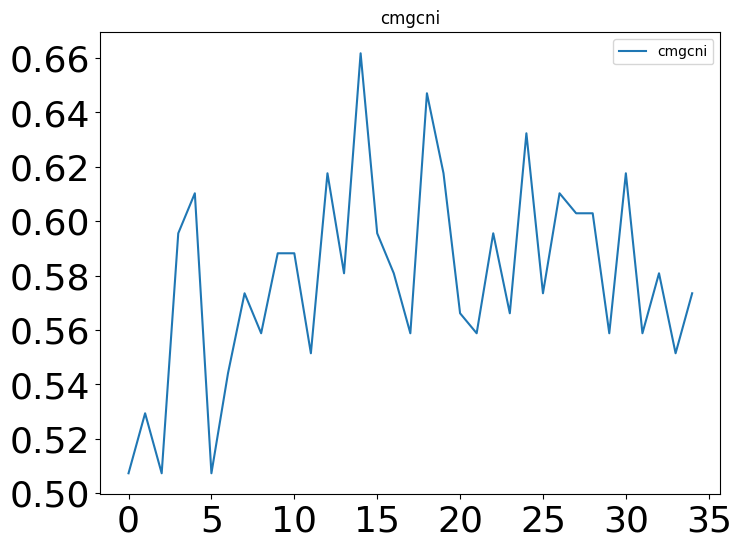

In [25]:
from configs import *
from cmgcni import train_cmgcni_model

logger = get_stderr_file_logger(log_file)
logging.info("This is an INFO message")
logging.warning("This is a WARNING message")

if flag_train:
    run_models()
    

## 消融实验

In [ ]:
# %run ablation.py

# attention visualization

In [26]:
# %run visualizations.py